<a href="https://colab.research.google.com/github/flokoafon/WQU_project/blob/WQU1/WQU_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
import pandas as pd
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import io
import datetime
import statsmodels.api as sm
from google.colab import files

In [32]:
url = "https://raw.githubusercontent.com/flokoafon/WQU_project/main/ProjectData.xlsx"
series = pd.read_excel(url)
series.head()

,Date,DPI,IPI,COP,SIR,LTIR,NGP
0,2000-01-01,6835.600098,76.49362,27.01,3.09,5.539524,NaN
1,2000-02-01,7644.549805,78.39347,29.30,3.14,5.508571,NaN
2,2000-03-01,7599.390137,78.49346,29.89,3.36,5.333043,NaN
3,2000-04-01,7414.680176,79.49338,25.54,3.53,5.225556,NaN
4,2000-05-01,7109.669922,81.39322,28.81,3.87,5.378182,NaN


As you'll see it in the report, the abreviations used above have the following meanings:
DPI: Dax Performance Index
IPI: Industrial Production Index
COP: Crude Oil Price
SIR: Short term Interest Rate
LTIR: Long-Term Interest Rate
NGP: Natural Gas Price

In [33]:
#Defining date column as index
#series['Date'] = pd.to_datetime(series['Date'], dayfirst = True)
series.set_index('Date', inplace = True)
series

,DPI,IPI,COP,SIR,LTIR,NGP
Date,,,,,,
2000-01-01,6835.600098,76.49362,27.01,3.09,5.539524,NaN
2000-02-01,7644.549805,78.39347,29.30,3.14,5.508571,NaN
2000-03-01,7599.390137,78.49346,29.89,3.36,5.333043,NaN
2000-04-01,7414.680176,79.49338,25.54,3.53,5.225556,NaN
2000-05-01,7109.669922,81.39322,28.81,3.87,5.378182,NaN
...,...,...,...,...,...,...
2021-11-01,15100.129883,94.29214,79.18,-0.52,-0.313636,NaN
2021-12-01,15884.860352,95.79202,71.69,-0.58,-0.384286,NaN
2022-01-01,15471.200195,96.39197,82.98,-0.50,-0.114762,NaN


In [35]:
#Select date where all series are available
#This because npg serie is only available between 01/01/2007 and 01/06/2021
intermediate = series.reset_index()
first = intermediate.loc[intermediate['Date']=='2007-01-01']
last = intermediate.loc[intermediate['Date']=='2021-06-01']
begin = first.index[0]
end = last.index[0]
complete_series = intermediate.loc[begin:end,]

In [36]:
#Complete_series is the dateframe containing all the rows of series with available data
complete_series

,Date,DPI,IPI,COP,SIR,LTIR,NGP
84,2007-01-01,6789.109863,95.09208,54.35,3.48,4.016818,2.4168
85,2007-02-01,6715.439941,95.49204,59.39,3.50,4.049000,2.4168
86,2007-03-01,6917.029785,95.99200,60.74,3.67,3.940909,2.4168
87,2007-04-01,7408.870117,95.09208,64.04,3.72,4.152105,2.4168
88,2007-05-01,7883.040039,96.79193,63.53,3.76,4.279048,2.4168
...,...,...,...,...,...,...,...
253,2021-02-01,13786.290039,95.19207,59.06,-0.26,-0.445500,2.0592
254,2021-03-01,15008.339844,95.89201,62.36,-0.12,-0.364783,2.0592
255,2021-04-01,15135.910156,95.69202,61.70,-0.25,-0.325000,2.0592
256,2021-05-01,15421.129883,95.19207,65.16,-0.34,-0.223500,2.0592


In the following cells, we plot the different series in order to have first apppreciations of their behaviors

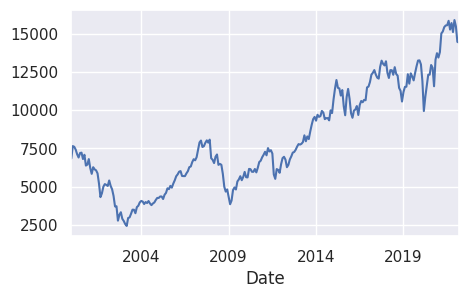

In [37]:
#First vizualisation of data
DPI = series['DPI']
DPI.plot()

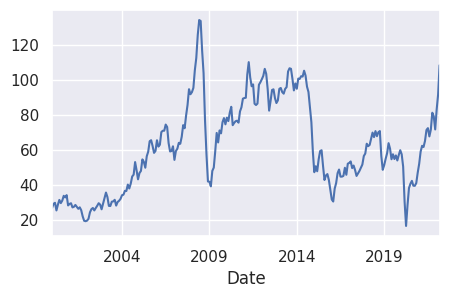

In [38]:
COP =series['COP']
COP.plot()

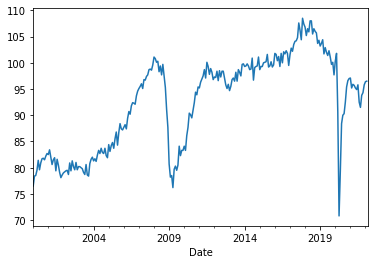

In [8]:
IPI = series['IPI']
IPI.plot()

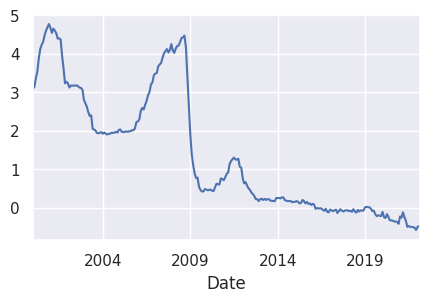

In [39]:
SIR = series['SIR']
SIR.plot()

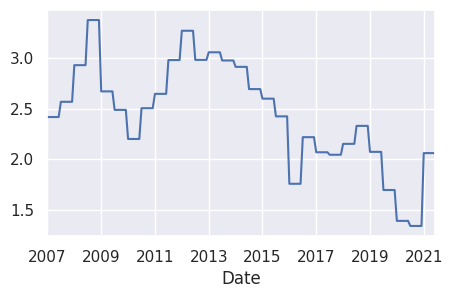

In [40]:
complete_series.set_index('Date', inplace = True)
NGP = complete_series['NGP']
NGP.plot()

In [41]:
# Compute some descriptive statistics
series.describe()

,DPI,IPI,COP,SIR,LTIR,NGP
count,267.000000,266.000000,267.000000,266.000000,267.000000,174.000000
mean,8100.129177,92.554318,61.425094,1.379850,2.304052,2.441931
std,3385.521911,8.941259,25.681007,1.610145,1.905739,0.514635
min,2423.870117,70.794100,16.700000,-0.580000,-0.649091,1.337200
25%,5603.625000,82.943088,40.970000,-0.017500,0.347702,2.071700
50%,7158.770020,95.592030,59.060000,0.615000,2.615909,2.487600
75%,11059.034668,99.391720,80.425000,2.657500,4.022273,2.914000
max,15884.860352,108.491000,134.020000,4.770000,5.539524,3.378000


In [43]:
# transformation of DPI, IPI and COP with the log function in order to ensure the same scale with  SIR, LTIR and NGP
series["logDPI"] = np.log(series["DPI"])
series["logIPI"] = np.log(series["IPI"])
series["logCOP"] = np.log(series["COP"])

# descriptive statistics on transformed variables
series[["logDPI","logIPI","logCOP"]].describe()

,logDPI,logIPI,logCOP
count,267.000000,266.000000,267.000000
mean,8.908218,4.523017,4.022872
std,0.437721,0.098640,0.450851
min,7.793121,4.259776,2.815409
25%,8.631169,4.418154,3.712832
50%,8.876093,4.560089,4.078554
75%,9.310950,4.599069,4.387276
max,9.673122,4.686667,4.897989


In [62]:
#Select date where all series are available and with log variables
intermediate = series.reset_index()
first = intermediate.loc[intermediate['Date']=='2007-01-01']
last = intermediate.loc[intermediate['Date']=='2021-06-01']
begin = first.index[0]
end = last.index[0]
complete_series = intermediate.loc[begin:end,]
complete_series.set_index('Date', inplace = True)

In [85]:
# Split of data : train and test samples
train= complete_series.iloc[:-12] # From 2007-01-01 to 2020-06-01
test=complete_series.iloc[-12:] # The last 12 months ( from 2020-07-01 to 2021-06-01)


# Studies on train sample

Text(0.5, 1.0, 'Log COP')

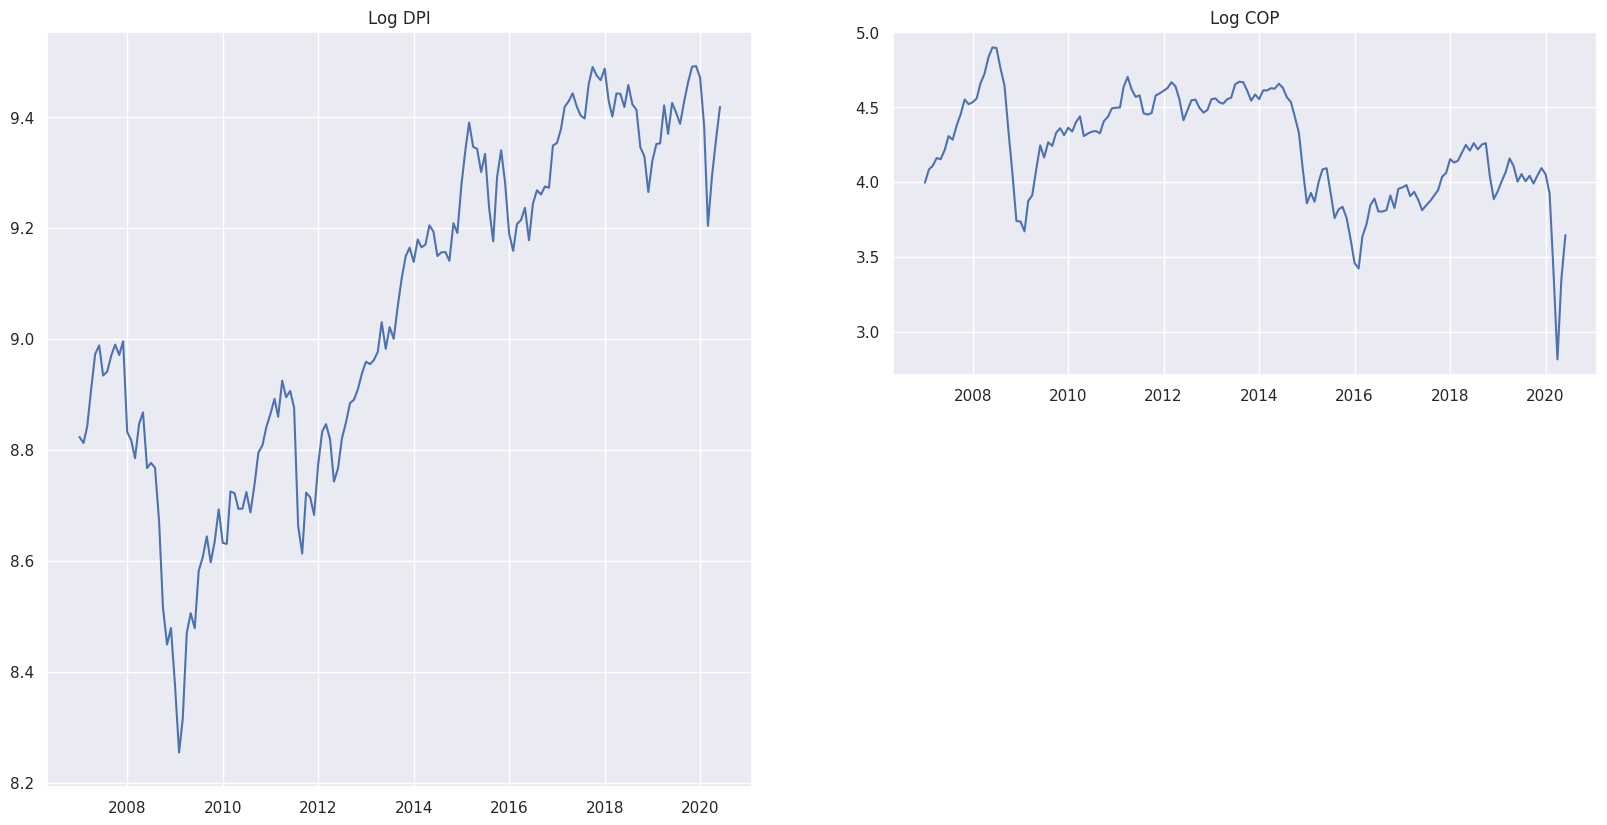

In [134]:
# Plots of the series
sns.set()
plt.figure(1,figsize=(20,10))
plt.subplot(1, 2, 1)
plt.plot(train["logDPI"])
plt.title("Log DPI")
plt.subplot(2, 2, 2)
plt.plot(train["logCOP"])
plt.title("Log COP")

Text(0.5, 1.0, 'SIR')

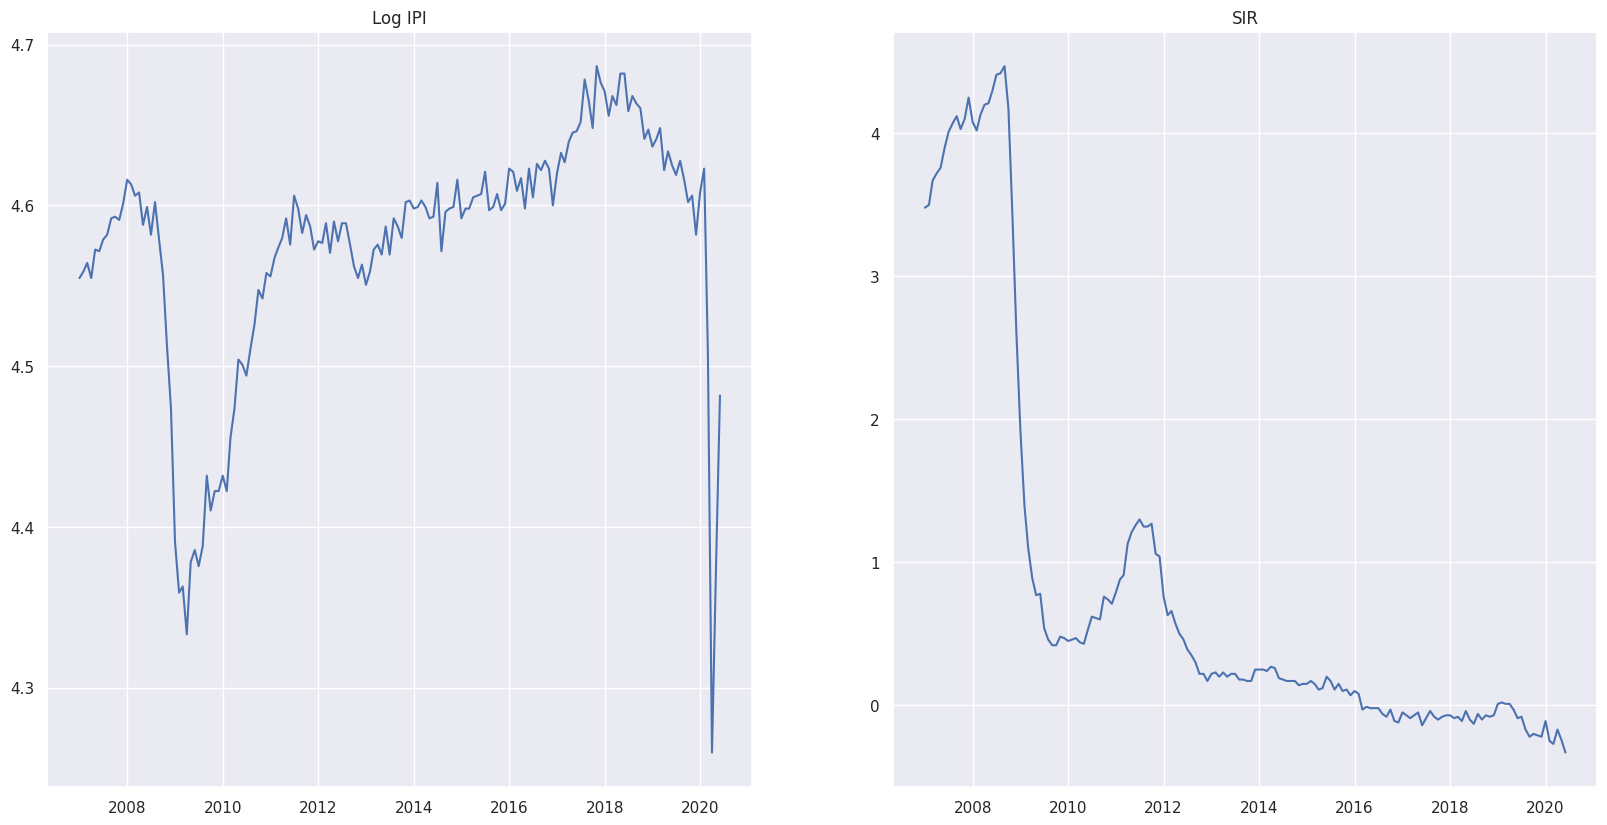

In [87]:
plt.figure(1,figsize=(20,10))
plt.subplot(1, 2, 1)
plt.plot(train["logIPI"])
plt.title("Log IPI")
plt.subplot(1, 2, 2)
plt.plot(train["SIR"])
plt.title("SIR")

Text(0.5, 1.0, 'NGP')

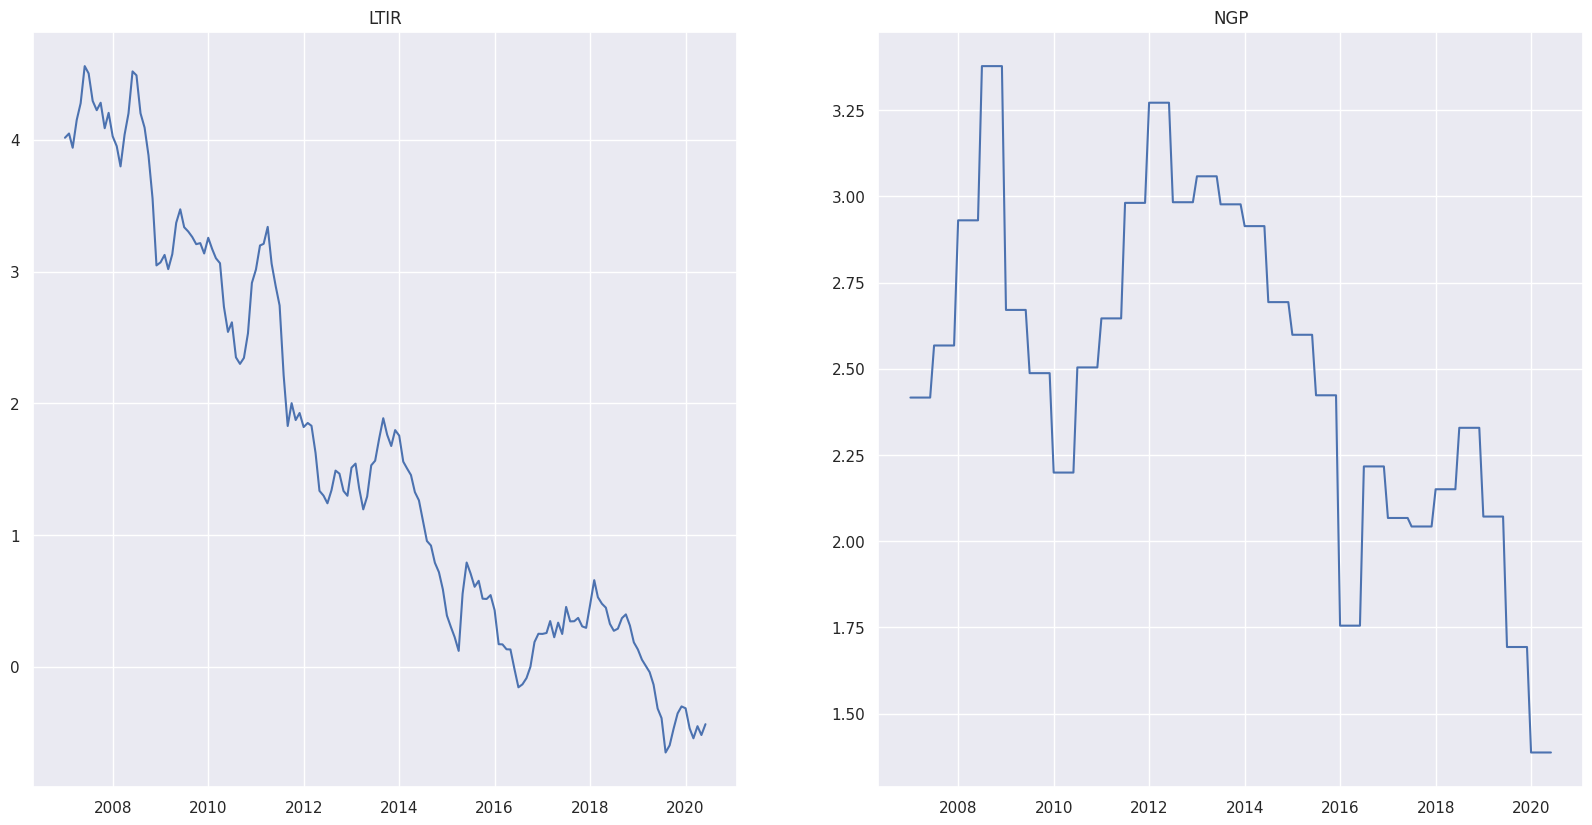

In [88]:
plt.figure(1,figsize=(20,10))
plt.subplot(1, 2, 1)
plt.plot(train["LTIR"])
plt.title("LTIR")
plt.subplot(1, 2, 2)
plt.plot(train["NGP"])
plt.title("NGP")


## Stationarity study

### Autocorrelation and partial autocorrelation with complete series

Text(0.5, 1.0, 'Partial Autocorrelation of logDPI')

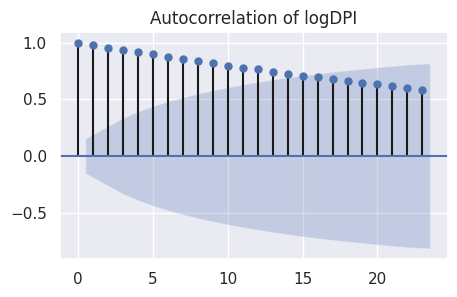

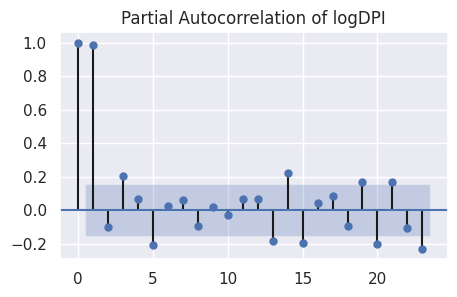

In [89]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

plt.rcParams.update({'figure.figsize':(5,3), 'figure.dpi':100}) 
plot_acf(train["logDPI"])
plt.title("Autocorrelation of logDPI") 

plt.rcParams.update({'figure.figsize':(5,3), 'figure.dpi':100}) 
plot_pacf(train["logDPI"])
plt.title("Partial Autocorrelation of logDPI") 

Text(0.5, 1.0, 'Partial Autocorrelation of logIPI')

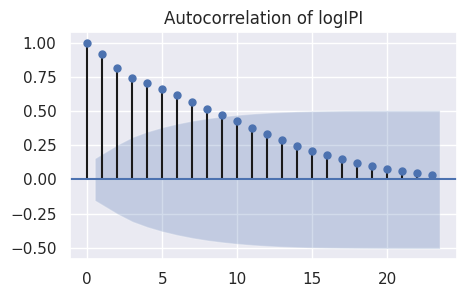

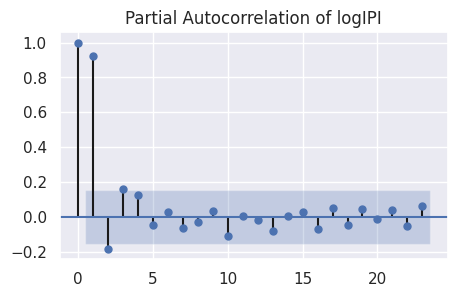

In [90]:
plot_acf(train["logIPI"])
plt.title("Autocorrelation of logIPI")

plot_pacf(train["logIPI"])
plt.title("Partial Autocorrelation of logIPI")

Text(0.5, 1.0, 'Partial Autocorrelation of logCOP')

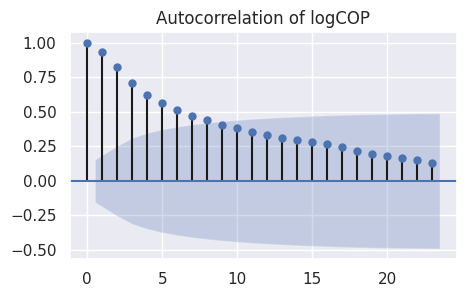

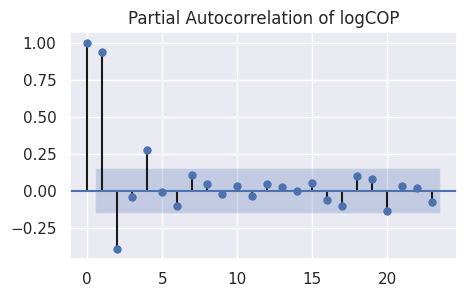

In [91]:
plot_acf(train["logCOP"])
plt.title("Autocorrelation of logCOP")

plot_pacf(train["logCOP"])
plt.title("Partial Autocorrelation of logCOP")

Text(0.5, 1.0, 'Partial Autocorrelation of SIR')

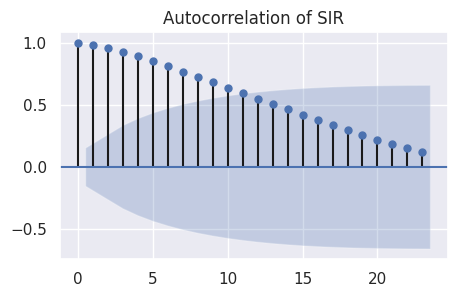

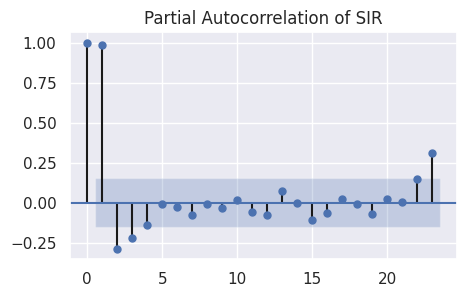

In [92]:
plot_acf(train["SIR"])
plt.title("Autocorrelation of SIR") 

plot_pacf(train["SIR"])
plt.title("Partial Autocorrelation of SIR")

Text(0.5, 1.0, 'Partial Autocorrelation of LTIR')

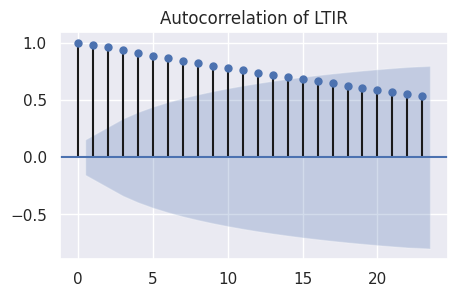

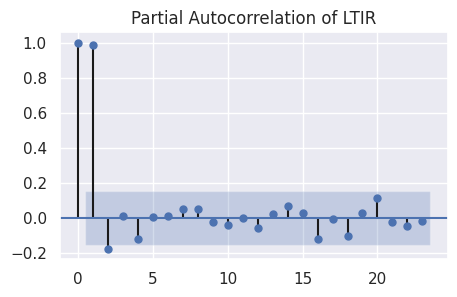

In [93]:
plot_acf(train["LTIR"])
plt.title("Autocorrelation of LTIR")

plot_pacf(train["LTIR"])
plt.title("Partial Autocorrelation of LTIR")

Text(0.5, 1.0, 'Partial Autocorrelation of NGP')

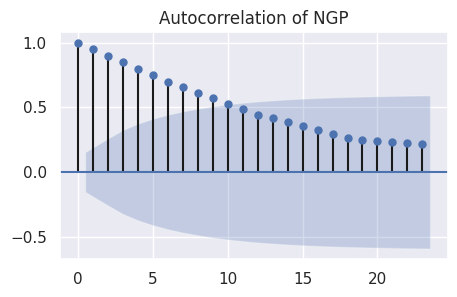

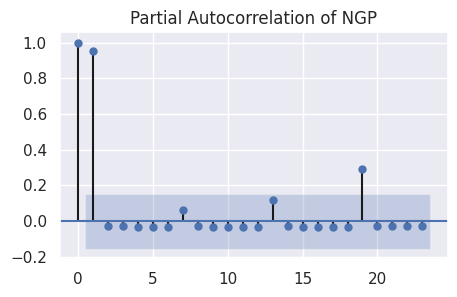

In [94]:
plot_acf(train["NGP"])
plt.title("Autocorrelation of NGP") 

plot_pacf(train["NGP"])
plt.title("Partial Autocorrelation of NGP") 

For each series, most of the autocorrelation are out of bounds and some partial autocorrelation too. This suggests that the series are not stationary. Below are presented the Augmented Dickey-Fuller (ADF) and the Phillips-Perron (PP) Tests which test the presence of an Unit Root. 

## Test of presence of unit root


### Augmented Dickey-Fuller Test. 

The null hypothesis to be tested is the presence of a unit root meaning that the series is not stationary. This test is based on an Autoregressive model with lag p (AR(p)) automatically determined by python and it assumes that the residuals are white noises. The model used is given below. 

$$ X_t-μ= \sum_{i=1}^p \phi_i (X_{t-i}-\mu) + \epsilon_t$$


In [104]:
from statsmodels.tsa.stattools import adfuller
adf_logDPI = adfuller(train["logDPI"]) 
adf_logIPI = adfuller(train["logIPI"])
adf_logCOP = adfuller(train["logCOP"])
adf_SIR = adfuller(train["SIR"])
adf_LTIR = adfuller(train["LTIR"])
adf_NGP = adfuller(train["NGP"])

print('The ADF Statistic of logDPI: %f' % adf_logDPI[0], ', the p value of logDPI: %f' % adf_logDPI[1], ' and the lag is :%f' % adf_logDPI[2])
print('The ADF Statistic of logIPI: %f' % adf_logIPI[0], ', the p value of logIPI: %f' % adf_logIPI[1], ' and the lag is :%f' % adf_logIPI[2] )
print('The ADF Statistic of SRI: %f' % adf_SIR[0], ', the p value of SRI: %f' % adf_SIR[1], ' and the lag is :%f' % adf_SIR[2])
print('The ADF Statistic of LTIR: %f' % adf_LTIR[0], ', the p value of LTIR: %f' % adf_LTIR[1], ' and the lag is :%f' % adf_LTIR[2])
print('The ADF Statistic of NGP: %f' % adf_NGP[0], ', the p value of NGP: %f' % adf_NGP[1], ' and the lag is :%f' % adf_NGP[2] )

The ADF Statistic of logDPI: -0.890583 , the p value of logDPI: 0.791058  and the lag is :2.000000
The ADF Statistic of logIPI: -1.866490 , the p value of logIPI: 0.347986  and the lag is :4.000000
The ADF Statistic of SRI: -2.225209 , the p value of SRI: 0.197224  and the lag is :4.000000
The ADF Statistic of LTIR: -1.545812 , the p value of LTIR: 0.510740  and the lag is :5.000000
The ADF Statistic of NGP: -0.841364 , the p value of NGP: 0.806669  and the lag is :0.000000


At the significant level of 5%, the null hypthesis is not rejected for any of the six series (because the p-value is greater than 5% for each series). So there is an Unit Root for each series, meaning that they are not stationary.

### Phillip-Perron (PP) test

The null hypothesis to be tested is the presence of a unit root meaning that the series is not stationary. Unlike the ADF test, the PP test does not assume that the residuals are white noises. It is based on the same model as ADF.

In [110]:
#!pip install arch
import arch.unitroot as at
pp_logDPI = at.PhillipsPerron(train["logDPI"], trend='ct', test_type="tau") 
pp_logIPI = at.PhillipsPerron(train["logIPI"], trend='ct', test_type="tau")
pp_logCOP = at.PhillipsPerron(train["logCOP"], trend='ct', test_type="tau")
pp_SIR = at.PhillipsPerron(train["SIR"], trend='ct', test_type="tau")
pp_LTIR = at.PhillipsPerron(train["LTIR"], trend='ct', test_type="tau")
pp_NGP = at.PhillipsPerron(train["NGP"], trend='ct', test_type="tau")

print('The PP Statistic of logDPI:', np.round(pp_logDPI.stat,6), 'and the PP p-value of logDPI:', np.round(pp_logDPI.pvalue,6))
print('The PP Statistic of logIPI:', np.round(pp_logIPI.stat,6), 'and the PP p-value of logIPI:', np.round(pp_logIPI.pvalue,6))
print('The PP Statistic of logCOP:', np.round(pp_logCOP.stat,6), 'and the PP p-value of logCOP:', np.round(pp_logCOP.pvalue,6))
print('The PP Statistic of SIR:', np.round(pp_SIR.stat,6), 'and the PP p-value of SIR:', np.round(pp_SIR.pvalue,6))
print('The PP Statistic of LTIR:', np.round(pp_LTIR.stat,6), 'and the PP p-value of LTIR:', np.round(pp_LTIR.pvalue,6))
print('The PP Statistic of NGP:', np.round(pp_NGP.stat,6), 'and the PP p-value of NGP:', np.round(pp_NGP.pvalue,6))

The PP Statistic of logDPI: -2.548956 and the PP p-value of logDPI: 0.303933
The PP Statistic of logIPI: -2.61731 and the PP p-value of logIPI: 0.271989
The PP Statistic of logCOP: -2.864558 and the PP p-value of logCOP: 0.174244
The PP Statistic of SIR: -1.911114 and the PP p-value of SIR: 0.648891
The PP Statistic of LTIR: -2.31404 and the PP p-value of LTIR: 0.4262
The PP Statistic of NGP: -2.284805 and the PP p-value of NGP: 0.442372


Also, the null hypothesis of the presence of an unit root is not rejected at a significant level of 5% for any of the 6 series, as with ADF test. So, none of these series is stationary.

### Stationarization of the series

Since each series seems to present a stochastic trend, the stationarization is going to be made by differenciating them until getting stationary series

In [132]:
# This function is going to be used to directly test by ADF and PP tests the stationarity of each series 
def get_stationarity(timeseries):
    # Dickey–Fuller Test:
    result = adfuller(timeseries)
    print('ADF Test results of',timeseries.name )
    print('Lag :{}'.format(result[2]))
    print('Statistic  : {}'.format(result[0]))
    print('p-value : {}'.format(result[1]))
    print('critical test values :')
    for key, value in result[4].items():
        print('\t{}: {}'.format(key, value))
    #Phillips-Perron Test:
    result1= at.PhillipsPerron(timeseries, trend='ct', test_type="tau") 
    print()
    print('PP Test results of',timeseries.name )
    print('Statistic : {}'.format(result1.stat))
    print('p-value : {}'.format(result1.pvalue))
    print()

**Log of DPI (logDPI)**

ADF Test results of logDPI
Lag :1
Statistic  : -9.739848292784547
p-value : 8.553558255663937e-17
critical test values :
	1%: -3.472161410886292
	5%: -2.8798954259680936
	10%: -2.5765565828092245

PP Test results of logDPI
Statistic : -10.972495359760435
p-value : 2.510894356284906e-17



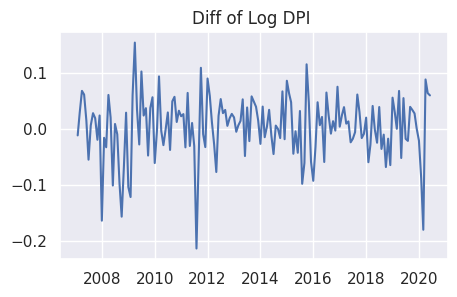

In [133]:
diff_logDPI= train["logDPI"] - train["logDPI"].shift()
diff_logDPI.dropna(inplace=True)
get_stationarity(diff_logDPI)
plt.plot(diff_logDPI)
plt.title("Diff of Log DPI ")
plt.show()

There is no unit root (p-value < 5%), so LogDPI differenciated once is stationary. So LogDPI is integrated at 1 (it is I(1)).

**Log of IPI (logIPI)**

ADF Test results of logIPI
Lag :1
Statistic  : -10.592655623316508
p-value : 6.467984602144981e-19
critical test values :
	1%: -3.472161410886292
	5%: -2.8798954259680936
	10%: -2.5765565828092245

PP Test results of logIPI
Statistic : -11.12665693225264
p-value : 1.2848547003692406e-17



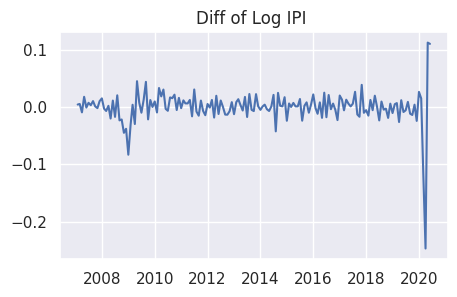

In [135]:
diff_logIPI= train["logIPI"] - train["logIPI"].shift()
diff_logIPI.dropna(inplace=True)
get_stationarity(diff_logIPI)
plt.plot(diff_logIPI)
plt.title("Diff of Log IPI ")
plt.show()

There is no unit root (p-value < 5%), so LogIPI differenciated once is stationary. So LogIPI is integrated at 1 (it is I(1)).

**Log of COP (logCOP)**

ADF Test results of logCOP
Lag :2
Statistic  : -7.5278231666178295
p-value : 3.644996436806477e-11
critical test values :
	1%: -3.4724305215713156
	5%: -2.8800127935315465
	10%: -2.576619230892485

PP Test results of logCOP
Statistic : -8.287658219360061
p-value : 1.5468596775763902e-11



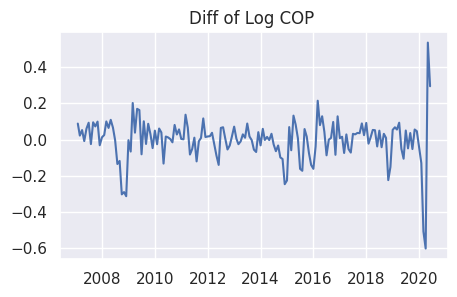

In [136]:
diff_logCOP= train["logCOP"] - train["logCOP"].shift()
diff_logCOP.dropna(inplace=True)
get_stationarity(diff_logCOP)
plt.plot(diff_logCOP)
plt.title("Diff of Log COP ")
plt.show()

There is no unit root (p-value < 5%), so LogCOP differenciated once is stationary. So LogCOP is integrated at 1 (it is I(1)).

**SIR**

ADF Test results of SIR
Lag :3
Statistic  : -5.093495047920857
p-value : 1.444742212430789e-05
critical test values :
	1%: -3.472703119504854
	5%: -2.880131672353732
	10%: -2.5766826861130268

PP Test results of SIR
Statistic : -5.00597514612171
p-value : 0.0002006528956323723



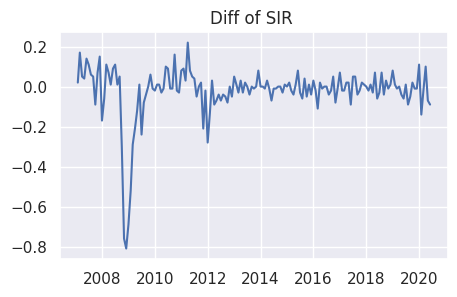

In [137]:
diff_SIR= train["SIR"] - train["SIR"].shift()
diff_SIR.dropna(inplace=True)
get_stationarity(diff_SIR)
plt.plot(diff_SIR)
plt.title("Diff of SIR ")
plt.show()

There is no unit root (p-value < 5%), so SIR differenciated once is stationary. So SIR is integrated at 1 (it is I(1)).

**LTIR**

ADF Test results of LTIR
Lag :4
Statistic  : -6.928995535448997
p-value : 1.0964262849314317e-09
critical test values :
	1%: -3.4729792729247793
	5%: -2.8802520918255534
	10%: -2.5767469641683105

PP Test results of LTIR
Statistic : -8.794634743491162
p-value : 1.0616518613165375e-12



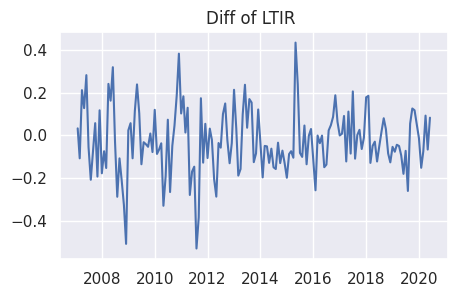

In [138]:
diff_LTIR= train["LTIR"] - train["LTIR"].shift()
diff_LTIR.dropna(inplace=True)
get_stationarity(diff_LTIR)
plt.plot(diff_LTIR)
plt.title("Diff of LTIR ")
plt.show()

There is no unit root (p-value < 5%), so LTIR differenciated once is stationary. So LTIR is integrated at 1 (it is I(1)).


**NGP**

ADF Test results of NGP
Lag :0
Statistic  : -12.60326061198598
p-value : 1.7176996631371195e-23
critical test values :
	1%: -3.4718957209472654
	5%: -2.8797795410156253
	10%: -2.5764947265625

PP Test results of NGP
Statistic : -12.729994700779862
p-value : 3.101035127037736e-20



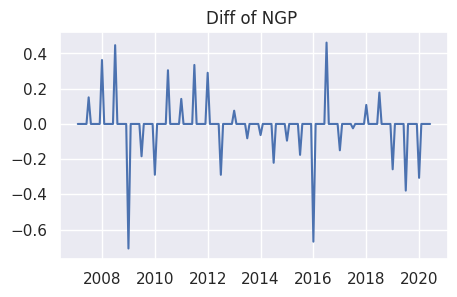

In [139]:
diff_NGP= train["NGP"] - train["NGP"].shift()
diff_NGP.dropna(inplace=True)
get_stationarity(diff_NGP)
plt.plot(diff_NGP)
plt.title("Diff of NGP ")
plt.show()

There is no unit root (p-value < 5%), so NGP differenciated once is stationary. So NGP is integrated at 1 (it is I(1)).

As each series is I(1), a Vector Error Model (VEC) could be applied if there is a cointégration between the series. But each series also shows a volatility.

In the followings we study seasonnality of each series by 

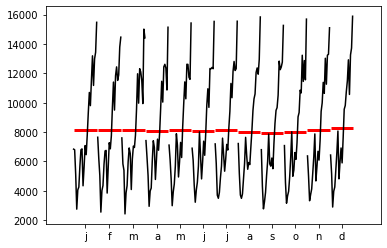

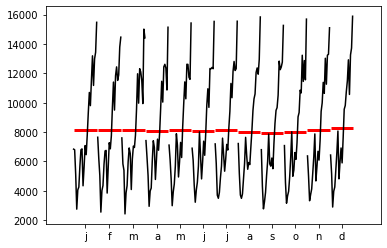

In [ ]:
#Monthplot for DPI
sm.graphics.tsa.month_plot(DPI)

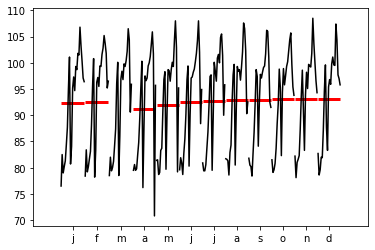

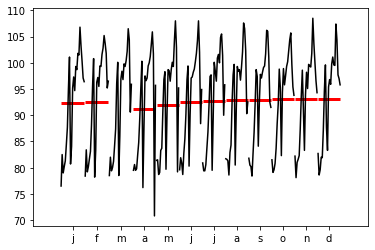

In [ ]:
#Monthplot for IPI
sm.graphics.tsa.month_plot(IPI)

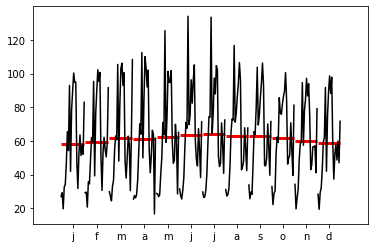

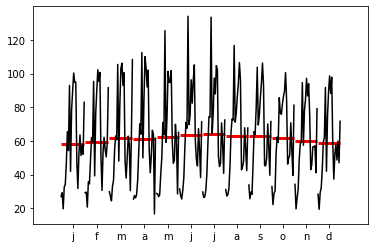

In [ ]:
#Monthplot for COP
sm.graphics.tsa.month_plot(COP)

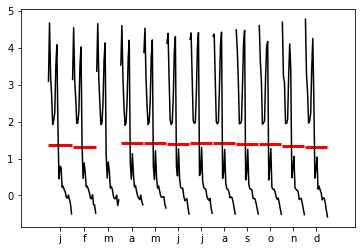

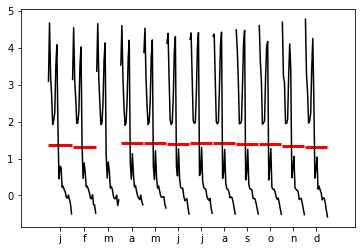

In [ ]:
#Monthplot for SIR
sm.graphics.tsa.month_plot(SIR)

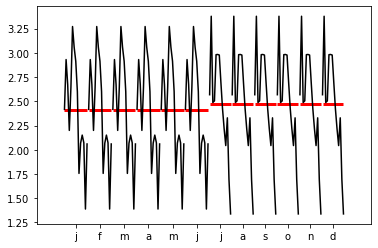

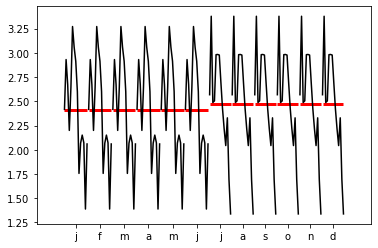

In [ ]:
#Monthplot for NGP
sm.graphics.tsa.month_plot(NGP)